In [1]:
import pickle
import yaml
import numpy as np

# all outputs can be generated with snakemake -c1 --use-conda data/140212114/injected/0.fluxes

# load original data
data = pickle.load(open("../data/140212114/injected/0.fluxes", "rb"))
# load info
info = yaml.safe_load(open("../data/140212114/info.yaml", "r"))
# period grids
periods = np.load("../data/140212114/periods.npy")
# gp
gp_params = yaml.safe_load(open("../data/140212114/gp.yaml", "r"))

Text(0, 0.5, 'differential flux')

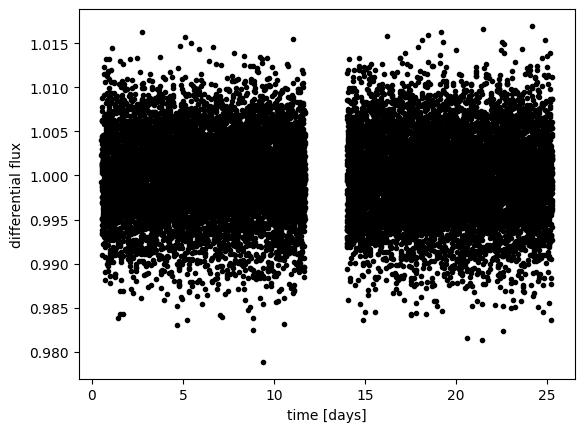

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# plot it
plt.plot(data["time"], data["flux"], ".k")
plt.xlabel("time [days]")
plt.ylabel("differential flux")


In [107]:
import sys

sys.path.append("../lib")
from tls import tls
from wotan import flatten


def trend(time, flux, window_length):
    return flatten(time, flux, window_length=window_length, return_trend=True)[1]


# $\texttt{wotan}_{3\times D}+\texttt{TLS}$

In [122]:
time, flux = data["time"], data["flux"]
verbose = True

flatten_trend = flatten(
    time, flux, window_length=data["transit_duration"] * 3, return_trend=True
)[1]
flatten_flux = flux - flatten_trend
flatten_flux -= np.mean(flatten_flux)
flatten_flux += 1.0

model = tls(time, flatten_flux, verbose=verbose)
results = model.power(
    periods,
    verbose=verbose,
    # use_threads=1,
    show_progress_bar=verbose,
    durations=[0.01, data["transit_duration"]],
)

t0, period, power = results["T0"], results["period"], results["power"]


Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 2 durations
Searching 15992 data points, 7680 periods from 0.3 to 11.0 days
Using all 10 CPU threads


100%|██████████| 7680/7680 periods | 00:06<00:00


Searching for best T0 for period 3.92508 days


100%|██████████| 9995/9995 [00:04<00:00, 2354.82it/s]


(1.0, 2.0)

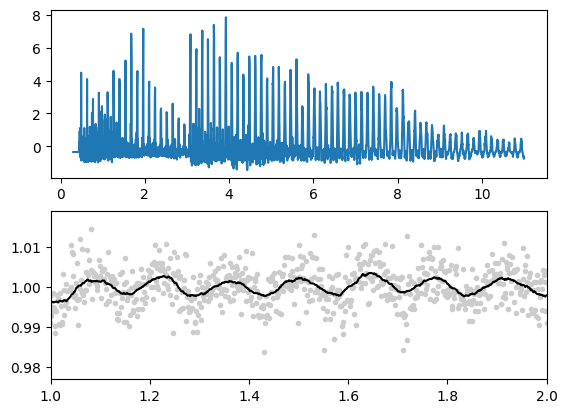

In [123]:
plt.subplot(211)
plt.plot(periods, power)

plt.subplot(212)
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, flatten_trend, "-k")
plt.xlim(1, 2)


# $\texttt{wotan}_{P/4}+\texttt{TLS}$

In [114]:
flatten_trend = flatten(
    time, flux, window_length=info["star_period"] / 4, return_trend=True
)[1]
flatten_flux = flux - flatten_trend
flatten_flux -= np.mean(flatten_flux)
flatten_flux += 1.0

model = tls(time, flatten_flux, verbose=verbose)
results = model.power(
    periods,
    verbose=verbose,
    # use_threads=1,
    show_progress_bar=verbose,
    durations=[0.01, data["transit_duration"]],
)

t0, period, power = results["T0"], results["period"], results["power"]


Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 2 durations
Searching 15992 data points, 7680 periods from 0.3 to 11.0 days
Using all 10 CPU threads


100%|██████████| 7680/7680 periods | 00:06<00:00


Searching for best T0 for period 0.46721 days


(1.0, 2.0)

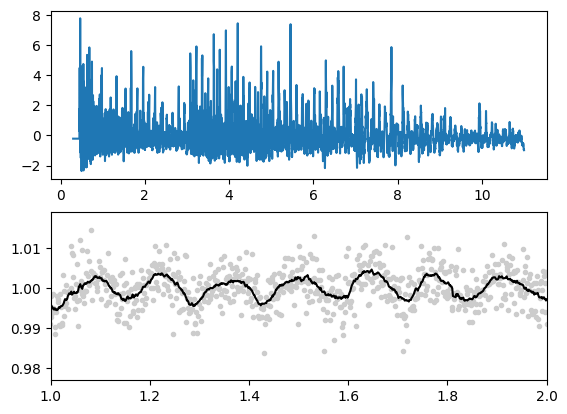

In [115]:
plt.subplot(211)
plt.plot(periods, power)

plt.subplot(212)
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, flatten_trend, "-k")
plt.xlim(1, 2)

# $\texttt{harmonics}+\texttt{TLS}$

In [118]:
# makes an harmonics design matrix of time
def make_harmonics(time, period, nharmonics=4):
    # make design matrix
    X = np.ones((len(time), 2 * nharmonics + 1))
    X[:, 1] = time
    for i in range(1, nharmonics):
        X[:, 2 * i + 1] = np.sin(2 * np.pi * i * time / period)
        X[:, 2 * i + 2] = np.cos(2 * np.pi * i * time / period)

    return X


X = make_harmonics(time, info["star_period"], nharmonics=2)
# solve for the coefficients
coeffs = np.linalg.solve(X.T @ X, X.T @ flux)
# make the model
flatten_trend = X @ coeffs
flatten_flux = flux - flatten_trend
flatten_flux -= np.mean(flatten_flux)
flatten_flux += 1.0

model = tls(time, flatten_flux, verbose=verbose)
results = model.power(
    periods,
    verbose=verbose,
    # use_threads=1,
    show_progress_bar=verbose,
    durations=[0.01, data["transit_duration"]],
)

t0, period, power = results["T0"], results["period"], results["power"]

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 2 durations
Searching 15992 data points, 7680 periods from 0.3 to 11.0 days
Using all 10 CPU threads


100%|██████████| 7680/7680 periods | 00:06<00:00


Searching for best T0 for period 3.92508 days


100%|██████████| 9995/9995 [00:04<00:00, 2299.25it/s]


(1.0, 2.0)

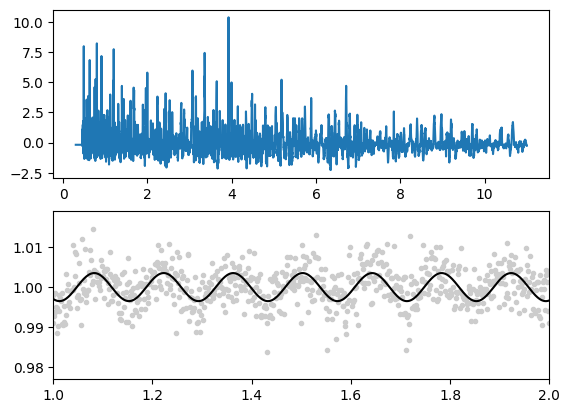

In [119]:
plt.subplot(211)
plt.plot(periods, power)

plt.subplot(212)
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, flatten_trend, "-k")
plt.xlim(1, 2)

# $\texttt{nuance}$

In [67]:
from nuance import Nuance
from nuance.kernels import rotation

# nuance
build_gp, _ = rotation(info["star_period"])
gp = build_gp(gp_params, data["time"])

nu = Nuance(data["time"], data["flux"], gp=gp)

nu.linear_search(data["time"], np.array([0.01, data["transit_duration"]]))
search = nu.periodic_search(periods)


100%|██████████| 9610/9610 [00:18<00:00, 510.47it/s]


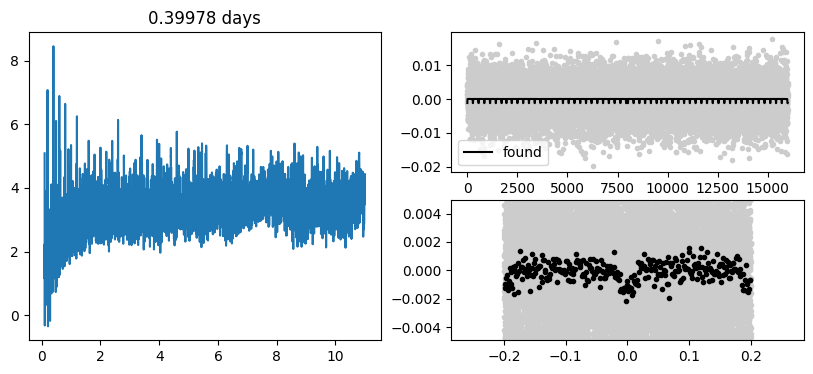

In [41]:
from nuance.utils import plot_search

plt.figure(None, (10, 4))
plot_search(nu, search)


(1.0, 2.0)

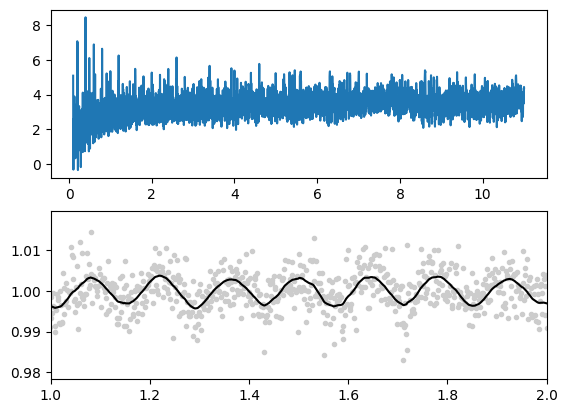

In [60]:
linear, astro, noise = nu.models(*search.best)

plt.subplot(211)
plt.plot(periods, search.Q_snr)

plt.subplot(212)
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, linear + noise, "-k")
plt.xlim(1, 2)


# Plots

In [3]:
def right_candidate(t0, period, true_t0, true_period, verbose=False):
    t0_check = (
        np.abs((t0 - true_t0 + 0.5 * true_period) % true_period - 0.5 * true_period)
        % period
        < 0.01
    )
    period_check = np.abs(period - true_period) < 0.01
    period_check |= np.abs(2 * period - true_period) < 0.01
    period_check |= np.abs(period / 2 - true_period) < 0.01
    same = period_check  # np.logical_and(t0_check, period_check)
    if verbose:
        if not same:
            if not t0_check:
                output = f"t0 differ: {t0:.2e} {true_t0:.2e}"
            if not period_check:
                output = f"period differ: {period:.2e} {true_period:.2e}"
        else:
            output = "match"
        return same, output
    else:
        return same


/Users/lgrcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in true_divide
  return (orbital_period * self.radius) / (np.pi * a)
/Users/lgrcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in true_divide
  return (orbital_period * self.radius) / (np.pi * a)
/Users/lgrcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in true_divide
  return (orbital_period * self.radius) / (np.pi * a)
/Users/lgrcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in true_divide
  return (orbital_period * self.radius) / (np.pi * a)


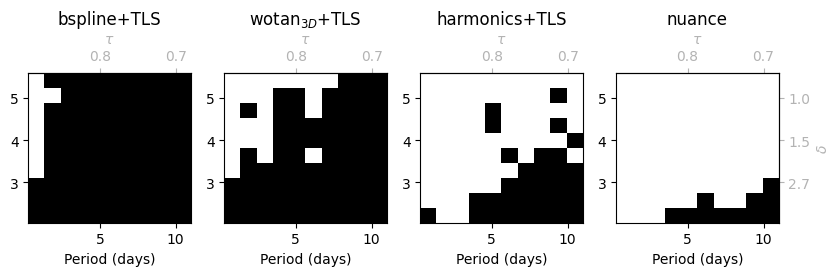

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from nuance.star import Star

methods = {
    "bspline": r"bspline+TLS",
    "wotan3D": r"wotan$_{3D}$+TLS",
    "harmonics": r"harmonics+TLS",
    "nuance": r"nuance",
}

star = Star(
    info["star_radius"], info["star_mass"], info["star_amplitude"], info["star_period"]
)

sec_color = "0.7"


plt.figure(None, (8.5, 1.35 * 8.5 / len(methods)))
for i, (name, title) in enumerate(methods.items()):
    ax = plt.subplot(1, len(methods), i + 1)
    df = pd.read_csv(f"../data/140212114/recovered/{name}/results.csv")
    df["found"] = df.apply(
        lambda row: right_candidate(
            row["t0"], row["period"], row["true_t0"], row["true_period"]
        ),
        axis=1,
    )
    radius, period, found, tau, delta = df[
        ["radius", "true_period", "found", "tau", "delta"]
    ].values.T

    # setting up ranges
    taus_range = np.min(tau), np.max(tau)
    deltas_range = np.min(delta), np.max(delta)
    periods_range = np.min(periods), np.max(periods)
    radii_range = np.min(radius), np.max(radius)
    extent = (*periods_range, *radii_range)

    plt.imshow(
        found.reshape((10, 10)).astype(bool),
        extent=[*periods_range, *radii_range],
        aspect="auto",
        cmap="Greys_r",
        origin="lower",
    )

    if i == len(methods) - 1:
        # secondary axes
        secax = ax.secondary_yaxis("right")
        radii_ticks = ax.get_yticks()
        delta_ticks = star.radius2delta(radii_ticks)
        secax.set_yticks(radii_ticks, [f"{t:.1f}" for t in delta_ticks])
        secax.set_ylabel(r"$\delta$", color=sec_color)
        secax.tick_params(axis="y", colors=sec_color)

    secax = ax.secondary_xaxis("top")
    period_ticks = ax.get_xticks()
    tau_ticks = star.period2tau(period_ticks)
    secax.set_xticks(period_ticks, [f"{t:.1f}" for t in tau_ticks])
    secax.set_xlabel(r"$\tau$", color=sec_color)
    secax.tick_params(axis="x", colors=sec_color)

    plt.xlabel("Period (days)")
    ax.set_title(title)

plt.tight_layout()

/Users/lgrcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in true_divide
  return (orbital_period * self.radius) / (np.pi * a)
/Users/lgrcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in true_divide
  return (orbital_period * self.radius) / (np.pi * a)
/Users/lgrcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in true_divide
  return (orbital_period * self.radius) / (np.pi * a)
/Users/lgrcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in true_divide
  return (orbital_period * self.radius) / (np.pi * a)


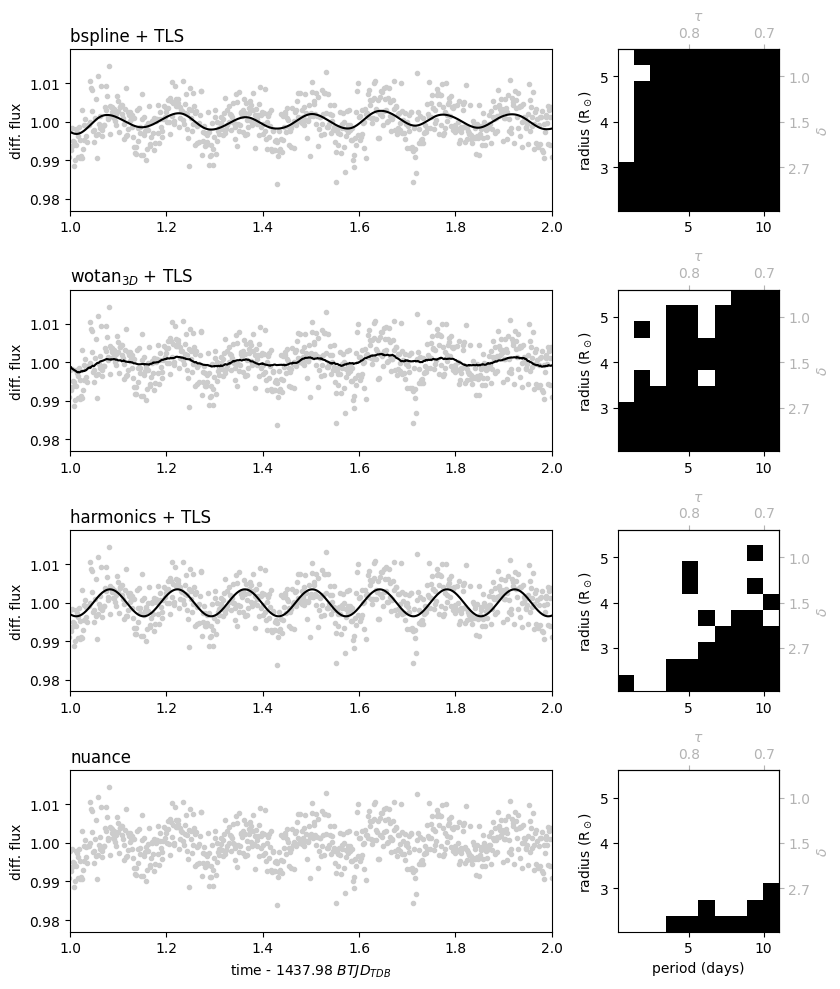

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from nuance.star import Star
from matplotlib import gridspec

methods = {
    "bspline": r"bspline + TLS",
    "wotan3D": r"wotan$_{3D}$ + TLS",
    "harmonics": r"harmonics + TLS",
    "nuance": r"nuance",
}
star = Star(
    info["star_radius"], info["star_mass"], info["star_amplitude"], info["star_period"]
)
sec_color = "0.7"
data = pickle.load(open(f"../data/140212114/injected/0.fluxes", "rb"))

# grid of plot with ratio 1:3
fig, axes = plt.subplots(
    nrows=len(methods), ncols=2, gridspec_kw={"width_ratios": [3, 1]}, figsize=(8.5, 10)
)
for i, (name, title) in enumerate(methods.items()):
    ax = axes[i, 1]
    df = pd.read_csv(f"../data/140212114/recovered/{name}/results.csv")
    trend = pickle.load(open(f"../data/140212114/recovered/{name}/0.params", "rb"))[
        "trend"
    ]
    df["found"] = df.apply(
        lambda row: right_candidate(
            row["t0"], row["period"], row["true_t0"], row["true_period"]
        ),
        axis=1,
    )
    radius, period, found, tau, delta = df[
        ["radius", "true_period", "found", "tau", "delta"]
    ].values.T

    # setting up ranges
    taus_range = np.min(tau), np.max(tau)
    deltas_range = np.min(delta), np.max(delta)
    periods_range = np.min(periods), np.max(periods)
    radii_range = np.min(radius), np.max(radius)
    extent = (*periods_range, *radii_range)

    ax.imshow(
        found.reshape((10, 10)).astype(bool),
        extent=[*periods_range, *radii_range],
        aspect="auto",
        cmap="Greys_r",
        origin="lower",
    )

    secax = ax.secondary_yaxis("right")
    radii_ticks = ax.get_yticks()
    delta_ticks = star.radius2delta(radii_ticks)
    secax.set_yticks(radii_ticks, [f"{t:.1f}" for t in delta_ticks])
    secax.set_ylabel(r"$\delta$", color=sec_color)
    secax.tick_params(axis="y", colors=sec_color)

    secax = ax.secondary_xaxis("top")
    period_ticks = ax.get_xticks()
    tau_ticks = star.period2tau(period_ticks)
    secax.set_xticks(period_ticks, [f"{t:.1f}" for t in tau_ticks])
    secax.set_xlabel(r"$\tau$", color=sec_color)
    secax.tick_params(axis="x", colors=sec_color)
    ax.set_ylabel("radius (R$_\odot$)")

    ax = axes[i, 0]
    ax.plot(data["time"], data["flux"], ".", c="0.8")
    if trend is not None:
        ax.plot(data["time"], trend, c="k")
    ax.set_xlim(1, 2)
    ax.set_ylabel("diff. flux")
    ax.set_title(title, loc="left")

axes[-1, 1].set_xlabel("period (days)")
axes[-1, 0].set_xlabel(f"time - {info['time0']:.2f} ${info['time0_format']}$")

plt.tight_layout()


# $\texttt{Bspline}+\texttt{TLS}$


In [98]:
import numpy as np

from scipy.interpolate import splrep, BSpline

mask = np.ones_like(data["time"], dtype=bool)
n = len(data["time"])

for i in range(2):
    tck = splrep(
        data["time"][mask],
        data["flux"][mask],
        w=1 / data["error"][mask],
        s=n + np.sqrt(n),
    )
    trend = BSpline(*tck)(data["time"])
    mask &= np.abs(data["flux"] - trend) < 3 * np.std(data["flux"] - trend)

trend = BSpline(*tck)(data["time"])

(0.96, 1.04)

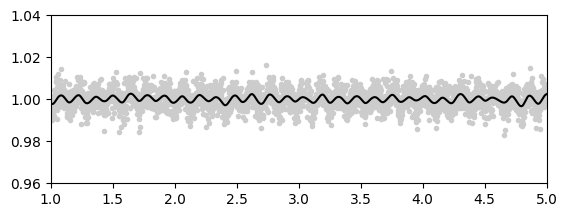

In [99]:
import matplotlib.pyplot as plt

trend2 = pickle.load(open("../data/140212114/recovered/bspline/80.params", "rb"))[
    "trend"
]

plt.subplot(212)
plt.plot(data["time"], data["flux"], ".", c="0.8")
plt.plot(data["time"], trend, "-k")
plt.xlim(1, 5)
plt.ylim(0.96, 1.04)

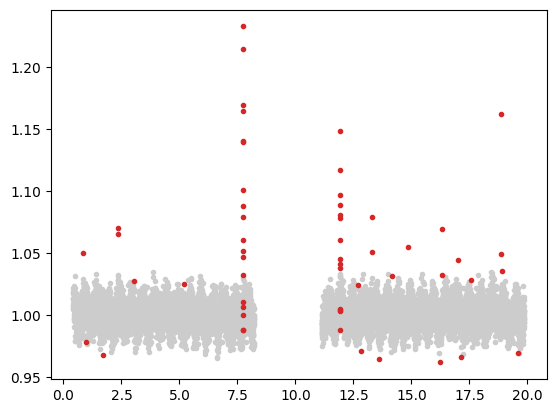

In [42]:
# plot masked flux
plt.plot(data["time"][mask], data["flux"][mask], ".", c="0.8")
plt.plot(data["time"][~mask], data["flux"][~mask], ".", c="C3")

In [48]:
#

import numpy as np
from scipy.signal import filtfilt, butter


def prewhiten_filter(x, fs, fc, order):
    """
    Apply a pre-whitening filter to a signal.

    Parameters:
    x (ndarray): Input signal.
    fs (float): Sampling rate (Hz).
    fc (float): Cutoff frequency of high-pass filter (Hz).
    order (int): Order of the high-pass filter.

    Returns:
    ndarray: Pre-whitened signal.
    """

    # Design high-pass filter
    nyquist_freq = 0.5 * fs
    cutoff_freq = fc / nyquist_freq
    b, a = butter(order, cutoff_freq, btype="highpass")

    # Apply high-pass filter forward and backward
    x_filt = filtfilt(b, a, x)

    # Compute standard deviation of filtered signal
    std_x_filt = np.std(x_filt)

    # Normalize filtered signal by its standard deviation
    x_filt_norm = x_filt / std_x_filt

    return x_filt_norm


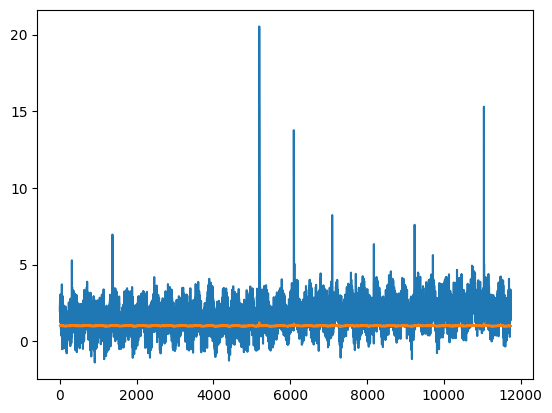

In [56]:
plt.plot(prewhiten_filter(flux, 2 / (2 / 60 / 24), 1 / (2 * 5 * 24), 2))
plt.plot(flux)


In [57]:
import numpy as np
from scipy.signal import butter, filtfilt


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


In [59]:
butter_bandpass(1 / 2000, 1 / 20, 2 / (2 / 60 / 24))


(array([ 1.35971462e-16,  0.00000000e+00, -5.43885849e-16,  0.00000000e+00,
         8.15828774e-16,  0.00000000e+00, -5.43885849e-16,  0.00000000e+00,
         1.35971462e-16]),
 array([  1.        ,  -7.9994356 ,  27.99604939, -55.98814864,
         69.98024854, -55.98024934,  27.98815009,  -7.99605019,
          0.99943576]))

In [60]:
import numpy as np
from scipy.signal import butter, sosfilt


def total_filter(signal, lowcut, highcut, fs, order=4):
    # Step 1: Design the filter
    nyquist_freq = 0.5 * fs
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    sos = butter(order, [low, high], btype="band", output="sos")

    # Step 2: Apply the filter
    filtered_signal = sosfilt(sos, signal)

    return filtered_signal


(1.0, 5.0)

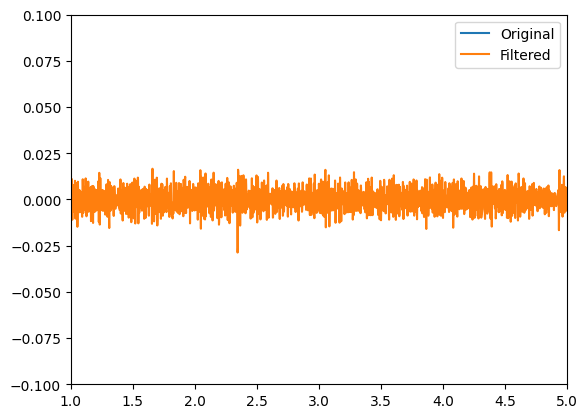

In [65]:
# Generate example signal
fs = 1000
t = np.arange(0, 1, 1 / fs)
signal = (
    np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 200 * t) + np.random.randn(len(t))
)

# Filter the signal
filtered_signal = total_filter(data["flux"], lowcut=60, highcut=240, fs=fs)

# Plot the original and filtered signals
import matplotlib.pyplot as plt

plt.plot(data["time"], data["flux"], label="Original")
plt.plot(data["time"], filtered_signal, label="Filtered")
plt.legend()
plt.ylim(-0.1, 0.1)
plt.xlim(1, 5)


In [ ]:
£